**In this notebook I predict Closing price.**

# RNN model baseline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE

##  Data exploration

In [4]:
#---load the Data: APPL 5 years
path = '../raw_data/NOKIA.HE.csv'
df = pd.read_csv(path)
print(df.head(10))
df.info()

         Date   Open   High    Low  Close  Adj Close    Volume
0  2016-06-07  5.045  5.090  5.030  5.040   4.394279  15646501
1  2016-06-08  5.040  5.070  5.000  5.035   4.389920  15821319
2  2016-06-09  5.040  5.070  5.000  5.025   4.381201  11421003
3  2016-06-10  5.045  5.085  4.970  4.984   4.345454  24756699
4  2016-06-13  4.950  5.125  4.890  5.060   4.411717  26540825
5  2016-06-14  5.005  5.095  4.944  4.944   4.310578  24439514
6  2016-06-15  5.010  5.055  4.936  5.050   4.402998  24600829
7  2016-06-16  5.010  5.135  5.005  5.075   4.424796  32994371
8  2016-06-17  4.920  4.926  4.808  4.858   4.320734  66884495
9  2016-06-20  4.940  4.990  4.916  4.940   4.393666  20725035
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1255 non-null   object 
 1   Open       1255 non-null   float64
 2   High       1255 non-null   float64
 

In [5]:
#---Data info
print(f"We have {df.shape[0]} observations in our unique Time Series with {df.shape[1]} initially given features: Date + {df.columns[1:].tolist()}")

We have 1255 observations in our unique Time Series with 7 initially given features: Date + ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [6]:
#---Sort values to make sure they are ordered *in case
df = df.sort_values('Date')

In [7]:
#---Select Features
#---TODO: feature importance
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = df.copy()[features]

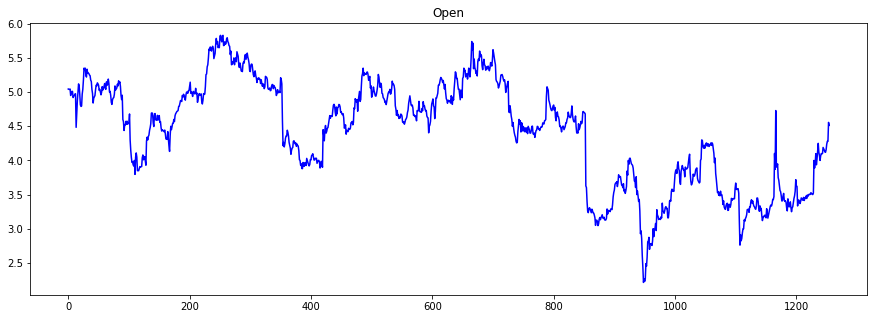

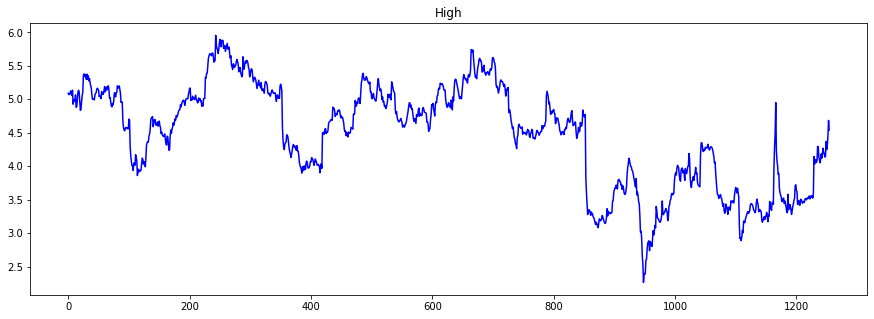

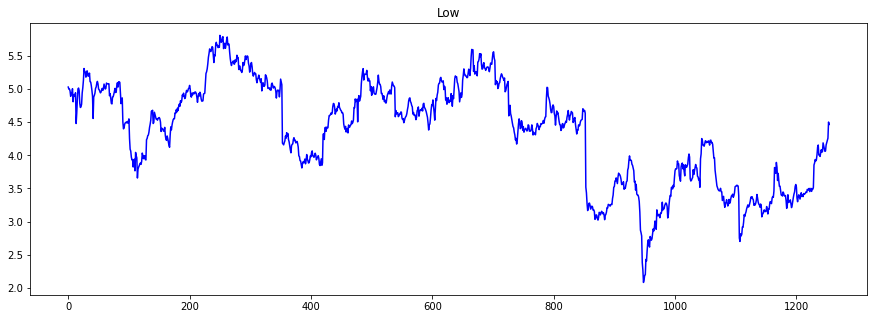

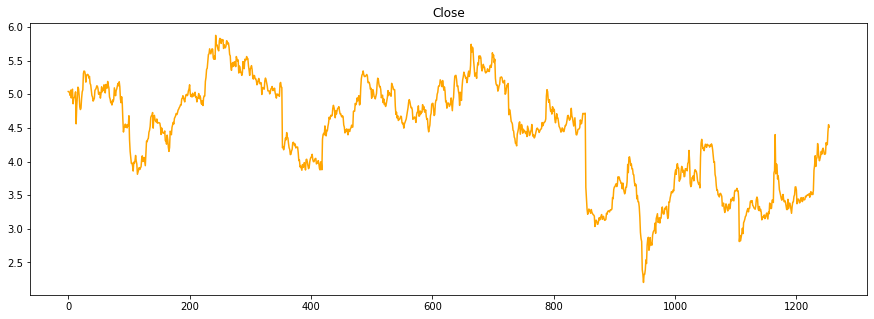

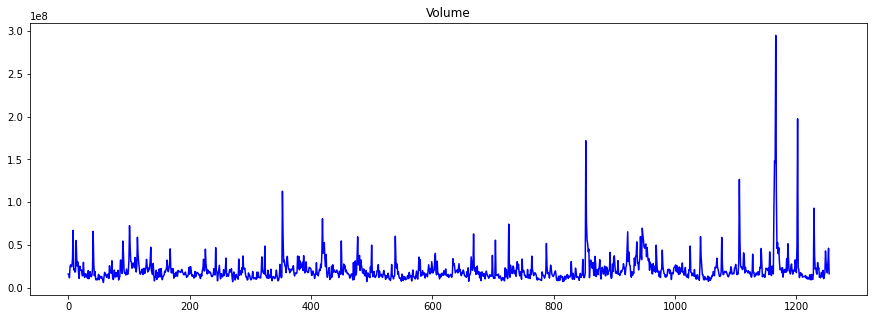

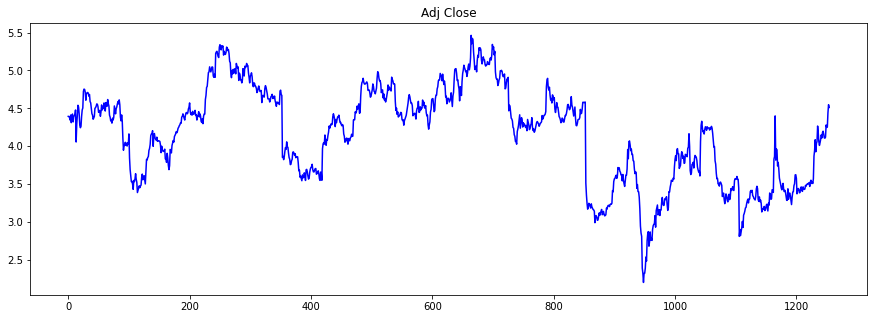

In [8]:
#---Plot the temporal progression of the different variables of our Data

%matplotlib inline

for col in data.columns:
    color="orange" if col == "Close" else "blue"
    data[col].plot(figsize=(15, 5), color=color)
    plt.title(col)

    plt.show()

*As wa can notice we should deel with a tendancy and be careful whan splitting data to train and test sets.*

## Train test split data

We need to split our data into a train, validation and test sets before creating the shorter sequences (to avoid having same values in the train and test set: data leakage). In resume:

- split your train and test set
- get your training and test sequences - and the corresponding output.

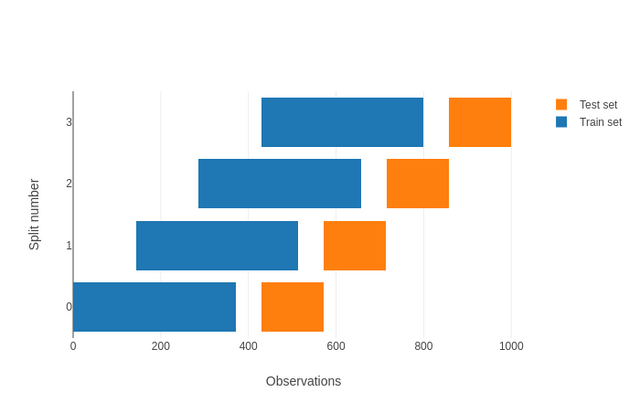

**Gap**

Gap matters when horizon > 1. Anyway, even if we use horizon=1, it can change later if we want to have prediction for 1 week from our last observation => horizon = 7.

A **gap between each train & test split** of size **horizon - 1** is mandatory to reflect real situations.

We chose our forecast horizon = 1 day.

**Some explanation from excercises on TS:**

Let's say we want our train set to end by **predicting day 21** based on days before **1, 2, 3,...,20.**
In a real situation we would need to wait for day **21** to discover the true value of y on which to finalize training.
Therefore, the **test set can only start on day 21**, which is meant to predict **y_test = 21 + 1**

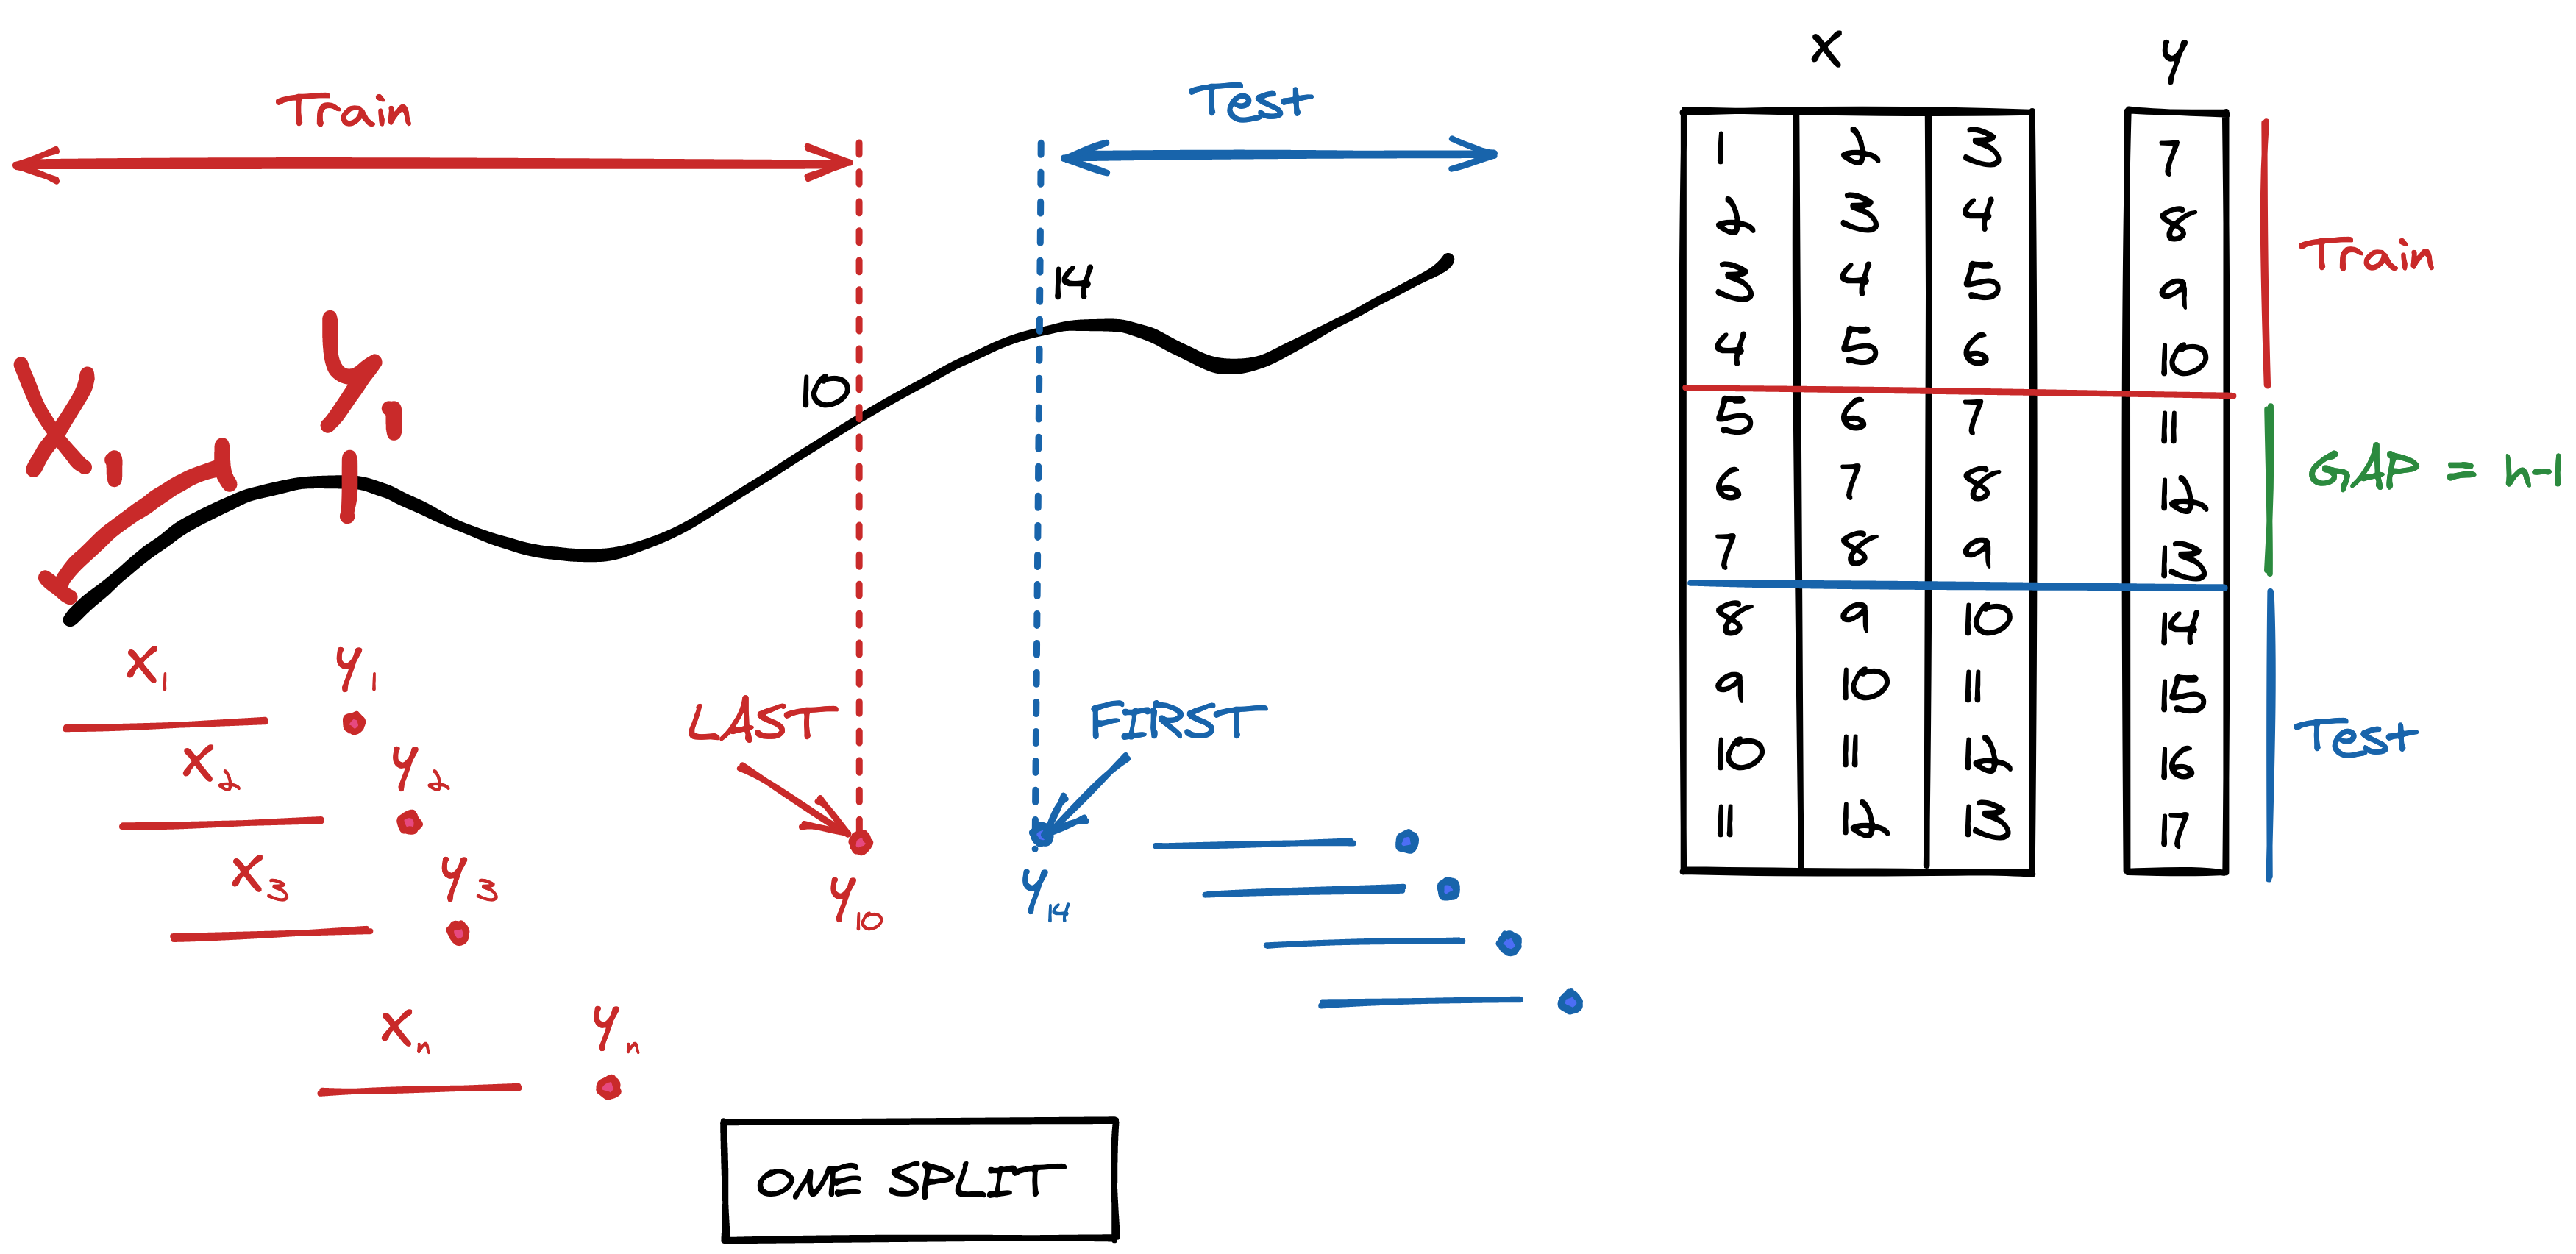

In [9]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [364]:
#---Goog train test split function if horizon=1, no notion of Gap

# 60% - train set,
# 20% - validation set,
# 20% - test set

# def train_test_split(df):

#     df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
#                        [int(.6*len(df)), int(.8*len(df))])
#     return df_train, df_val, df_test

# df_train, df_val, df_test = train_test_split(df_without_date)

## Functions: subsampling

Subsamples this dataset into a shorter sequence of length length
- Stores the value of closing price of the last day as your variable array y
- Stores all features of previous days as a variable X
- Returns (X, y)

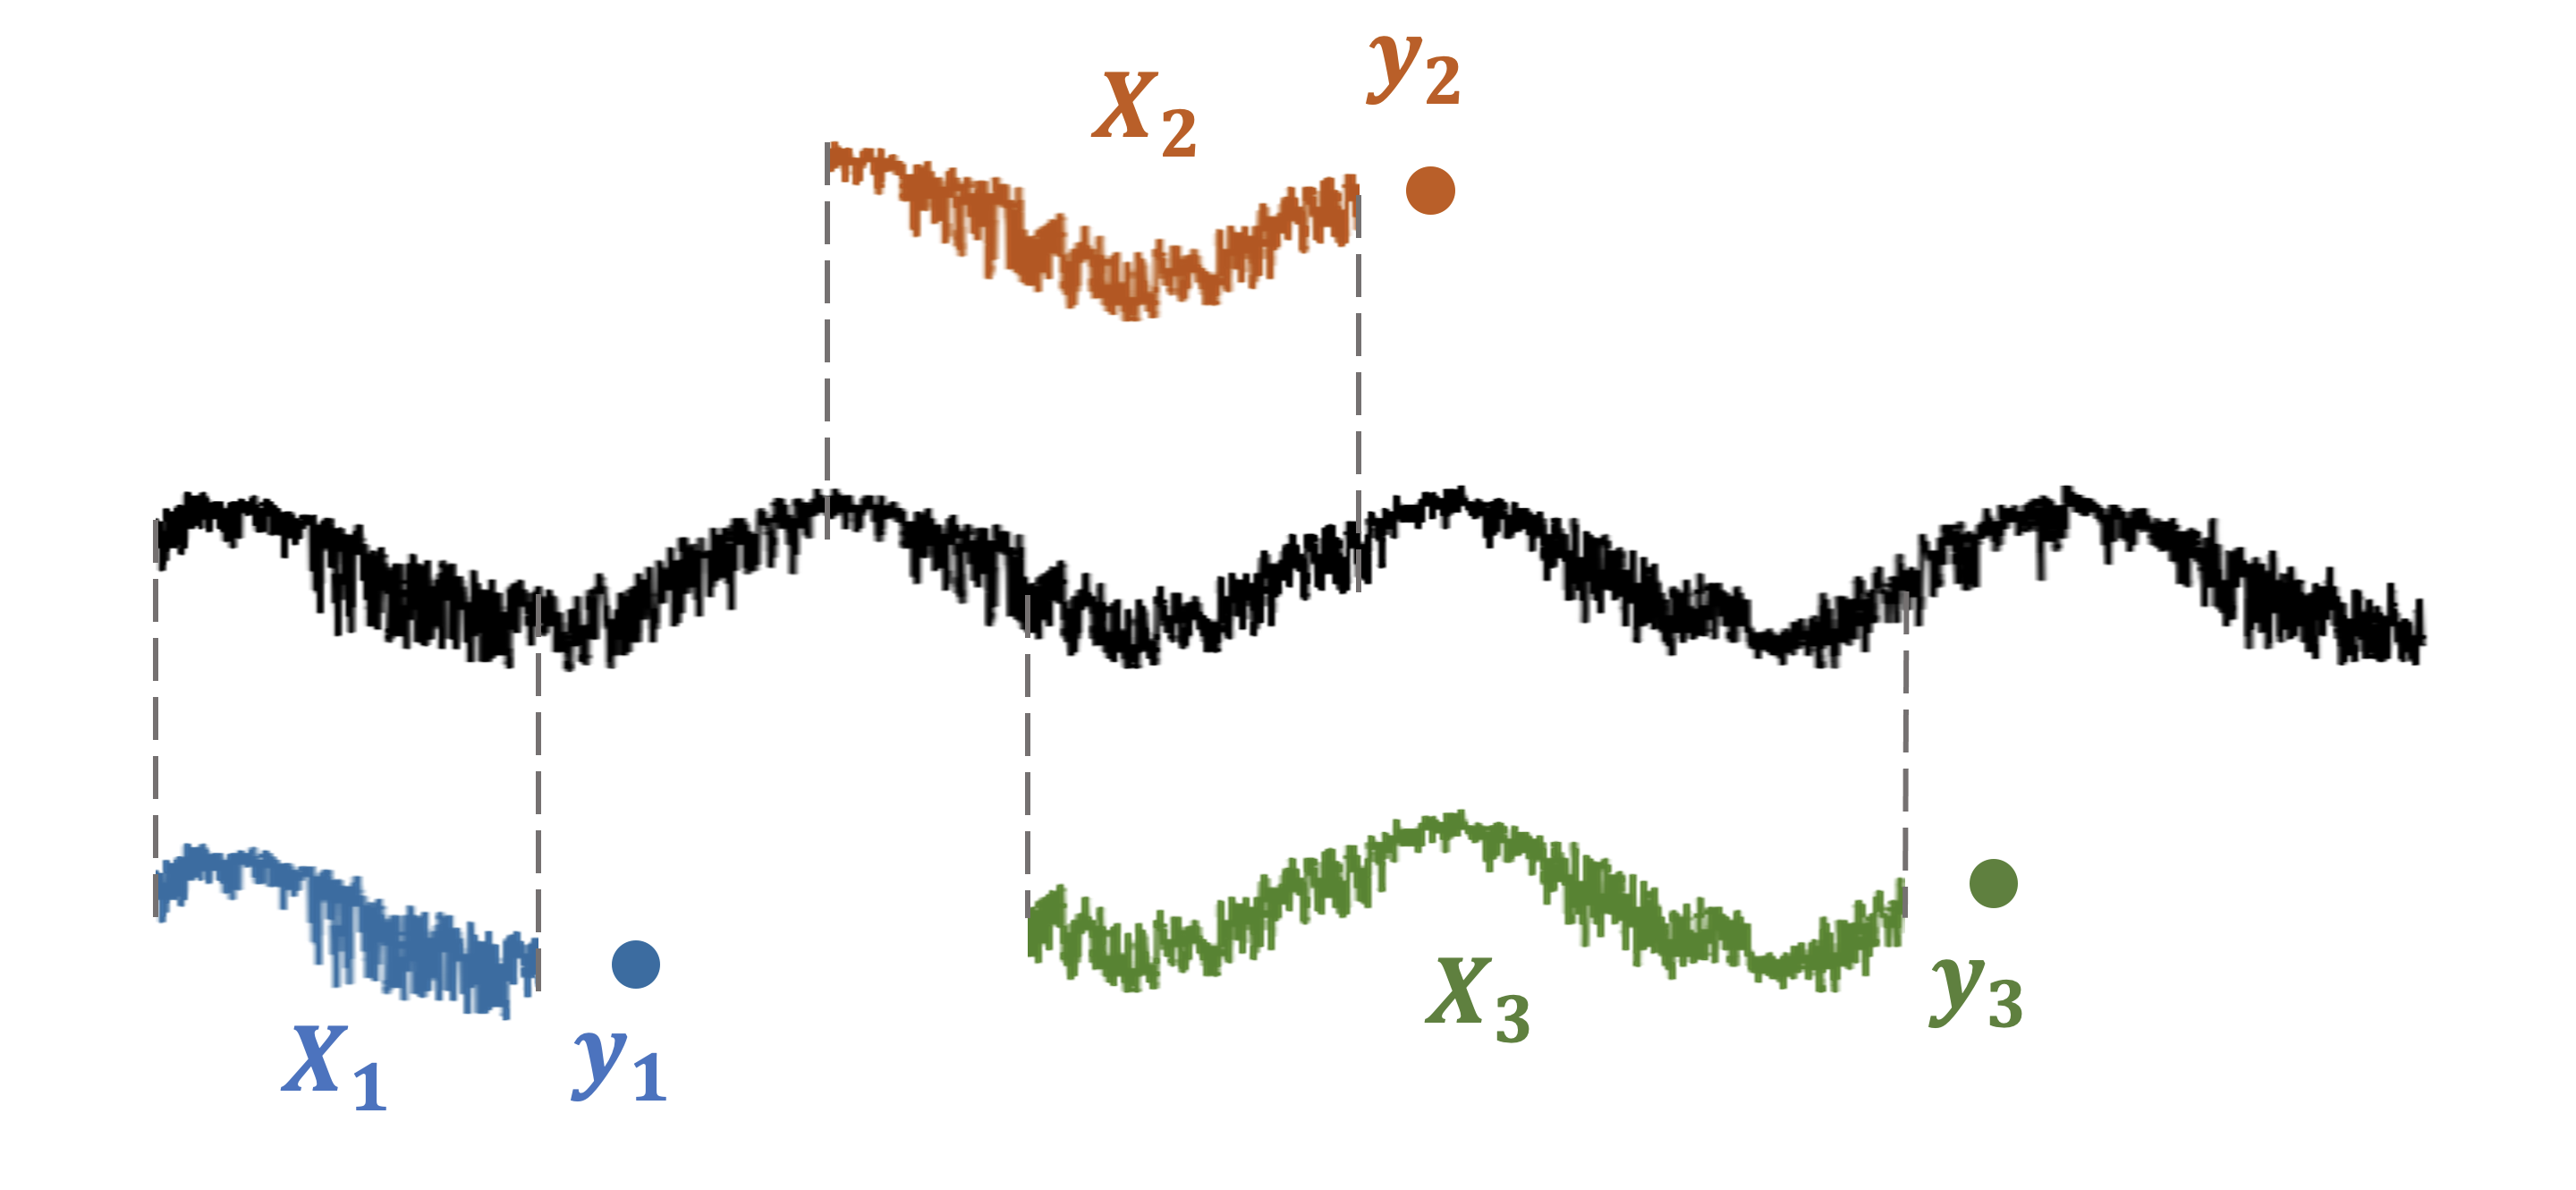

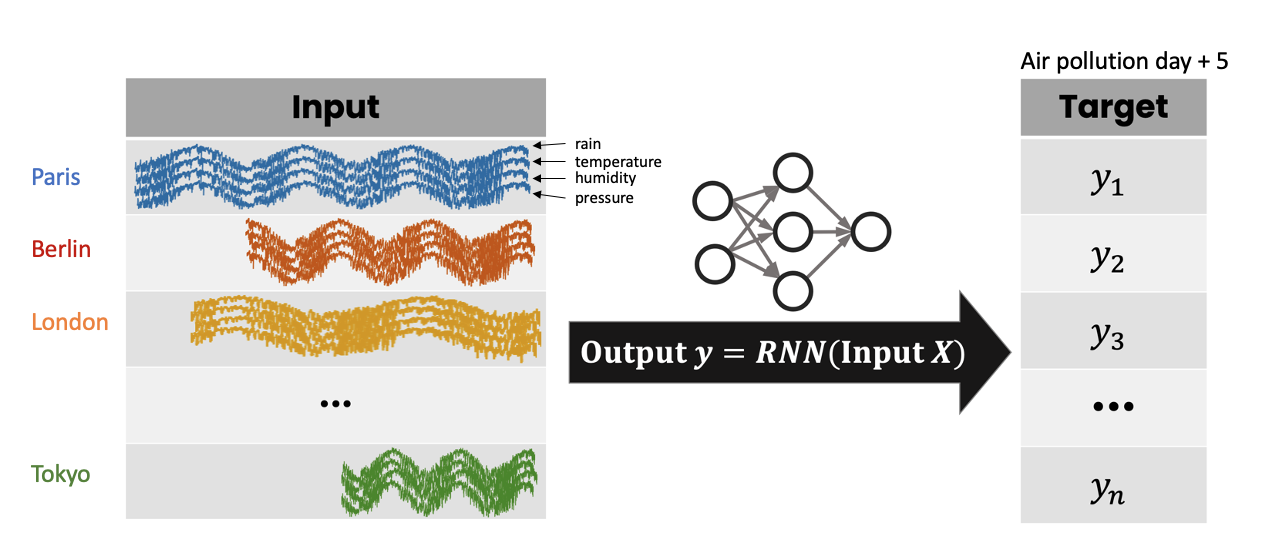

### Create a function subsample_sequence: 

This function is able to get a **subsequence  X**  and a corresponding **target y**  which corresponds to the stock closing price **N days** after the last observation - horizon.

- If we want to prerdict the next day => horizon = 1
- Length of subsequence is to choose, I take 10 observations here.

In [10]:
def subsample_sequence(df, length=10, horizon=1):
    
    """This function is able to get a subsequence X and a corresponding target y
    N days after the last observationexpressed in horizon variable."""
    
    last_possible = df.shape[0] - length - horizon
    
    random_start = np.random.randint(0, last_possible) #raandom seed  = 0
    
    X = df[random_start: random_start+length].values
    
    # target: Close price to predict
    y = df.iloc[random_start+length+horizon]['Close'] #change for return

    return X, y

### Create a function get_X_y

This function updates the previous one.

Prevously, we've created only one sample (Xi, yi). **Let's write a function to repeat this operation and get multiple samples, then concatenate them to create our final dataset (X, y).**

Let's define a **length of sequences**: it could be a list that corresponds to the **lenght of each sample Xi** as lenght of each sample could be different [len(X1),..., len(Xn)] or a fixed value => we take a fixed value of 100 sequences per TS.

In [17]:
def get_X_y(df, length=10, horizon=1, number_of_sequences=100):
    
    """This function returns a given number of X and y sequences of given length."""
    
    X, y = [], []

    for _ in range(int(number_of_sequences)):
        
        xi, yi = subsample_sequence(df, length, horizon)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Train, val, test sequences

Finally, let's use previous functions that we've created to get our training, validation and test sequences - and the corresponding output y.

In [18]:
#---Split data to train, validation, test sets
#---here you can test different sizes for split !

df_train, df_val, df_test = train_test_val_split(data) #train_threshold=0.6, val_threshold=0.8 to test !

print(f"train shape: {df_train.shape}\nval shape: {df_val.shape}\ntest shape: {df_test.shape}\n")

train shape: (753, 6)
val shape: (251, 6)
test shape: (251, 6)



TODO: Train test val graphs to plot in different colors for demo to explain our choice of thresholds.

In [19]:
#---Get train, test, val sequences
#---here you can test different length, number of sequences !
#---params by default: length=10, horizon=1, number_of_sequences=100

X_train, y_train = get_X_y(df_train, length=10, number_of_sequences=400)
X_val, y_val = get_X_y(df_val, length=10)
X_test, y_test = get_X_y(df_test, length=10)
print(f"We have {X_train.shape[0]} sequences of {X_train.shape[1]} observations per feature:\nX_train shape: {X_train.shape}\nX_val shape: {X_val.shape}\nX_test shape: {X_test.shape}\n")

We have 400 sequences of 10 observations per feature:
X_train shape: (400, 10, 6)
X_val shape: (100, 10, 6)
X_test shape: (100, 10, 6)



In [39]:
data.columns.to_list()

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

[5.2   5.218 5.35  5.316 5.32  5.222 5.25  5.268 5.19  5.246]


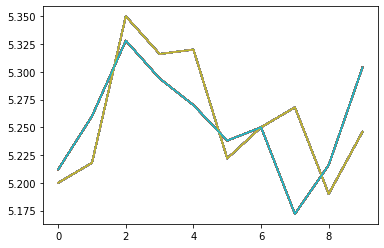

In [14]:
# ---Plot observations of 1st sequence for Open and Close prices
for _ in range(100):
    plt.plot(X_train[0,:,0])
    plt.plot(X_train[0,:,3])
print(X_train[0,:,0])

*Note: As we have chosen same length for all sub sequences we do not need to pad ! Great !!!*

## Build a simple RNN Model

Let's use **MAPE** metrics from tf.keras.metrics.
MAPE computes the **mean absolute percentage** error between y_true and y_pred.
It's a measure of prediction accuracy of a forecasting method in statistics.

Before building a model:
- Scale features if needed
- Look at the scale of your target: If smaller than usual, increase the learning rate vs. default values!
- Plot your loss history to get visual feedback

In [20]:
#---Initialize model
def init_model():
    metric = MAPE
    opt = RMSprop(learning_rate=0.01)
    
    normalizer = Normalization()
    #train normalizer on our train set
    normalizer.adapt(X_train)

# as we use normailization layer: no need for input shape
    model = Sequential()
    
    model.add(normalizer)
    model.add(layers.LSTM(20, activation='tanh')) #input_shape=(10,6) is sequential
    #last fully connected layers
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    #---Copmile model
    model.compile(loss='mse', optimizer=opt, metrics=[metric]) #loss=MAPE, learning rate
    
    return model

In [21]:
model = init_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, None, 6)           13        
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,394
Trainable params: 2,381
Non-trainable params: 13
_________________________________________________________________


In [45]:
#---Test different model syntax to resolve normalization shape error

# from tensorflow.keras import Model, Input

# def init_model_test():
#     normalizer = Normalization()
#     normalizer.adapt(X_train)
    
#     input_shape = X_train.shape[1:]
    
#     # Create a model that include the normalization layer
#     inputs = Input(shape=input_shape)
#     x = normalizer(inputs)
#     x = layers.LSTM(10, activation='tanh')(x)
#     x = layers.Dense(10, activation='relu')(x)
    
#     outputs = layers.Dense(1, activation="linear")(x)
#     model = Model(inputs, outputs)
    
#     #---Copmile model
#     model.compile(loss='MAPE', optimizer=RMSprop(learning_rate=0.01), metrics=MAPE)
    
#     return model

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

patience=10
es = EarlyStopping(patience=patience, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), #spli=>0.3
                    epochs=1000,
                    batch_size=32,
                    verbose=1,
                    callbacks=[es])

Epoch 1/1000
13/13 [==============================] - 4s 81ms/step - loss: 7.6041 - mean_absolute_percentage_error: 43.8786 - val_loss: 0.1482 - val_mean_absolute_percentage_error: 8.8972
Epoch 2/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0906 - mean_absolute_percentage_error: 4.8872 - val_loss: 0.2200 - val_mean_absolute_percentage_error: 10.6609
Epoch 3/1000
13/13 [==============================] - 0s 20ms/step - loss: 0.0680 - mean_absolute_percentage_error: 4.3779 - val_loss: 0.1795 - val_mean_absolute_percentage_error: 9.5024
Epoch 4/1000
13/13 [==============================] - 0s 21ms/step - loss: 0.0985 - mean_absolute_percentage_error: 5.3332 - val_loss: 0.4036 - val_mean_absolute_percentage_error: 15.3778
Epoch 5/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0745 - mean_absolute_percentage_error: 4.5993 - val_loss: 0.2741 - val_mean_absolute_percentage_error: 12.5652
Epoch 6/1000
13/13 [==============================] - 0s 17ms

In [89]:
#---Plot train val losses function

def plot_loss(history):
    plt.plot(history.history['loss']) # plot train loss
    plt.plot(history.history['val_loss']) # plot val loss
    plt.title('MSE')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mean_absolute_percentage_error'])
    plt.plot(history.history['val_mean_absolute_percentage_error'])
    plt.title('MAPE')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [90]:
stop_epoch = max(history.epoch)-patience
val_mape = history.history['val_mean_absolute_percentage_error'][stop_epoch]

17.093809127807617

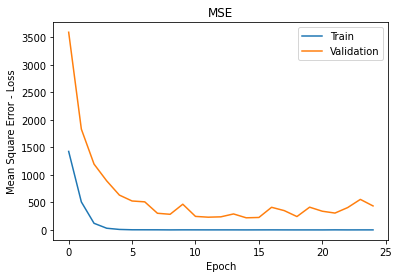

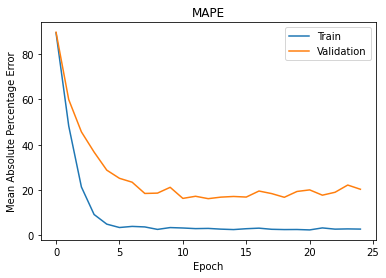

early stopping at 24 epoch.


In [108]:
plot_loss(history)
print(f"early stopping at {max(history.epoch)} epoch.\val mape: {val_mape}")

**How can we know if we get a good accuracy ?**

=> we need a **benchmark value**. Let's take the **mean of y_train** as a prediction and compute it.

In [92]:
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 65.76 %


In [93]:
# # Or (better) we predict the last stock closing price value!
# y_pred_baseline = X_test[:,-1,0]
# bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
# print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

In [94]:
#---Compute the prediction with our model
loss, mape = model.evaluate(X_test, y_test, verbose=0)
print(f'MAPE on the test set : {mape:.2f} %')

MAPE on the test set : 72.54 %


## Build Stacked RNN

All **Stacked RNN** (EXCEPT the last one) should have the **return_sequences set to True** so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

The **additional hidden layers** are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction.
A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

In [110]:
#---Stacked RNN

def init_model_2():
    metric = MAPE
    opt = RMSprop(learning_rate=0.005)
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = Sequential()
    model.add(normalizer)
    
    # Stacked layers
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    # Fully connected layers
    
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

model_2 = init_model_2()

patience_2=30
es = EarlyStopping(patience=patience_2, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,     # compile with same sequences as before to compare model performance
            validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=32,
            callbacks=[es], verbose=0)

In [111]:
stop_epoch_2 = max(history_2.epoch)-patience_2
val_mape_2 = history_2.history['val_mean_absolute_percentage_error'][stop_epoch_2]

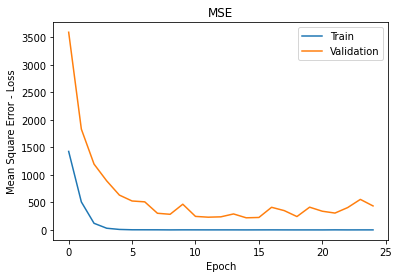

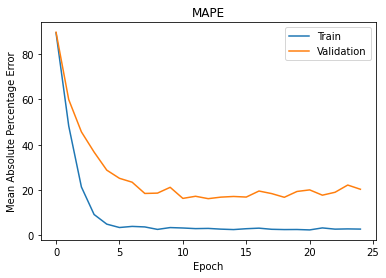

early stopping at 86 epoch.
val_mape: 14.824540138244629


In [112]:
plot_loss(history)
print(f"early stopping at {max(history_2.epoch)} epoch.\nval_mape: {val_mape_2}")

In [120]:
res_2 = model_2.evaluate(X_test, y_test, verbose=0)
res_2[1]

53.011436462402344

## Train model function

This function:
- Allows to **split sequences** and gets X and y for train, val, test sets;
- **Initializes stacked RNN model** with Normalization, **LSTM** and 2 fully connected layers;
- All the parameters are to test ! => will use **tensor board** after 2 tests to find optimal **nb of sequences** and **sequence length**.

In [ ]:
from sklearn.model_selection import KFold

#TODO: integer K-fold cross validation

def k_fold_cross_val(df):

    X, y = get_X_y(df)
    kf = KFold(n_splits=2)
    kf.get_n_splits(X)

    KFold(n_splits=4, random_state=None, shuffle=False)
    for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    return X_train, X_test, y_train, y_test

In [ ]:
def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

df_train, df_val, df_test = train_test_val_split(data) #train_threshold=0.6, val_threshold=0.8 to test !

In [115]:
def train_model(df,
                nb_sequences = 400,
                len_ = 20,
                l_rate = 0.01,
                loss = 'mse',
                metric = MAPE,
                patience = 30,
                batch_size = 32,
                horizon=1,
                plot_history=False):
    
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes stacked RNN model with Normalization, LSTM and 2 fully connected layers"""

    # Get train, test, val sets
    df_train, df_val, df_test = train_test_val_split(df)
    
    # Train, test, val split
    X_train, y_train = get_X_y(df_train, length=len_, number_of_sequences=nb_sequences)
    X_val, y_val = get_X_y(df_val, length=len_, number_of_sequences=round(nb_sequences*0.2))
    X_test, y_test = get_X_y(df_test, length=len_, number_of_sequences=round(nb_sequences*0.2))

    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    
    model.compile(loss=loss, 
                  optimizer=RMSprop(learning_rate=l_rate), 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=batch_size,
            callbacks=[es],
            verbose=0)

    
    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()
        print(f"early stopping at {max(history.epoch)} epoch.\nval_mape: {history.history['val_mean_absolute_percentage_error'][(max(history.epoch)-patience)]:.2f}")
     
    res = model.evaluate(X_test, y_test, verbose=0)
    
    return res[1]

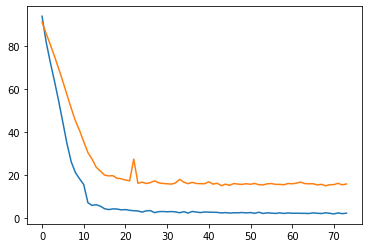

early stopping at 73 epoch.
val_mape: 14.92


[4417.58740234375, 53.60063552856445]

In [116]:
#(df_without_date,
train_model(df=data, plot_history=True)

## Tests to find optimal number of sequences and sequence length.

In [125]:
#---Annexe

def get_max_sample():
    """Function that allows automatically define max number of sequences in a given dataset"""
    
    max_sample = 1
    for i in range(1, len(data)):
        if len(data) % i == 0: #i is a sample size
            max_sample = i
    
    return max_sample
        
get_max_sample()

629

In [145]:
#---Test 1: nb_sequences

def test_nb_sequences(df, start=100, stop=600, step=50):
    
    """This function computes MAPE in given range
    to find best nb_sequences"""
    
    nb_sequences_grid = np.arange(start, stop, step)
    MAPE = []

    for nb_sequences in nb_sequences_grid:
            res = train_model(df, nb_sequences=nb_sequences)
            MAPE.append((nb_sequences, round(res[1])))
            print(f"For {nb_sequences} sequences the MAPE is of {res[1]:.2f} %")

In [146]:
# prevous test showed that I could min the range of training as following

test_nb_sequences(df= data, 250,450,20)

For 250 sequences the MAPE is of 58.19 %
For 270 sequences the MAPE is of 52.51 %
For 290 sequences the MAPE is of 56.58 %
For 310 sequences the MAPE is of 54.38 %
For 330 sequences the MAPE is of 53.61 %
For 350 sequences the MAPE is of 54.45 %
For 370 sequences the MAPE is of 54.76 %
For 390 sequences the MAPE is of 53.92 %
For 410 sequences the MAPE is of 54.20 %
For 430 sequences the MAPE is of 53.49 %


In [149]:
#---Test 2: length of sequence

def test_len_sequence(df, start=10, stop=30, step=5):
    
    """This function computes MAPE in given range
    to find best nb_sequences"""
    
    len_grid = np.arange(start, stop, step)
    MAPE = []

    for len_ in len_grid:
            res = train_model(df, len_=len_)
            MAPE.append((len_, round(res[1])))
            print(f"For lenght of sequence {len_} the MAPE is of {res[1]:.2f} %")

In [150]:
test_len_sequence(df = data, 10, 30, 5)

For lenght of sequence 10 the MAPE is of 53.22 %
For lenght of sequence 15 the MAPE is of 54.40 %
For lenght of sequence 20 the MAPE is of 52.79 %
For lenght of sequence 25 the MAPE is of 56.24 %


In [153]:
#---Test nb_sequences and len_
def grid(df, start_len = 10,stop_len = 30, step_len = 5,
            start_nbs = 270, stop_nbs = 330, step_nbs=10):
    
    """This function computes MAPE in given range
    to find best nb_sequences AND the optimal lenght of sequences."""
    
    len_grid = np.arange(start_len,stop_len, step_len)
    nb_sequences_grid = np.arange(start_nbs,stop_nbs, step_nbs)
    MAPE = []

    for len in len_grid:
        for nb_sequences in nb_sequences_grid:
            res = train_model(df, nb_sequences=100)
            MAPE.append((nb_sequences, len_, res[1]))

            print(f"For {nb_sequences} sequences of lenght {len_} each, the MAPE is of {res[1]:.2f} %")

In [154]:
grid(df=data)

TypeError: train_model() got multiple values for argument 'nb_sequences'

In [ ]:
import matplotlib
x = [res[0] for res in MAPE] # n_days
y = [res[1] for res in MAPE] # n_seq
c = [res[2] for res in MAPE] # MAPE  
plt.scatter(x, y, c=c, norm=matplotlib.colors.Normalize(vmin=20, vmax=50, clip=False), cmap='coolwarm')